# Dataset: Housing dataset
### Predict house prices → Supervised regression 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

In [3]:
df = pd.read_csv("housing.csv")

In [4]:
print("Shape:", df.shape)

Shape: (5000, 7)


In [5]:
display(df.head())

,Avg. Area Income,Avg. Area House Age,Avg. Area Number of Rooms,Avg. Area Number of Bedrooms,Area Population,Price,Address
0,79545.45857,5.682861,7.009188,4.09,23086.80050,1.059034e+06,"208 Michael Ferry Apt. 674\nLaurabury, NE 3701..."
1,79248.64245,6.002900,6.730821,3.09,40173.07217,1.505891e+06,"188 Johnson Views Suite 079\nLake Kathleen, CA..."
2,61287.06718,5.865890,8.512727,5.13,36882.15940,1.058988e+06,"9127 Elizabeth Stravenue\nDanieltown, WI 06482..."
3,63345.24005,7.188236,5.586729,3.26,34310.24283,1.260617e+06,USS Barnett\nFPO AP 44820
4,59982.19723,5.040555,7.839388,4.23,26354.10947,6.309435e+05,USNS Raymond\nFPO AE 09386


In [6]:
print("\nMissing Values:\n", df.isnull().sum())


Missing Values:
 Avg. Area Income                0
Avg. Area House Age             0
Avg. Area Number of Rooms       0
Avg. Area Number of Bedrooms    0
Area Population                 0
Price                           0
Address                         0
dtype: int64


In [7]:
possible_targets = ["price", "Price", "PRICE", "SalePrice", "saleprice", "target"]


In [8]:
target_col = None
for col in possible_targets:
    if col in df.columns:
        target_col = col
        break

if target_col is None:
    print("\nTarget column not found automatically.")
    print("Available columns:", df.columns.tolist())
    target_col = input("Enter the target column name (house price): ")

print("\nTarget column selected:", target_col)


Target column selected: Price


In [9]:
X = df.drop(columns=[target_col])
y = df[target_col]

In [10]:
num_cols = X.select_dtypes(include=["int64", "float64"]).columns
cat_cols = X.select_dtypes(include=["object"]).columns

In [11]:
print("\nNumeric Columns:", list(num_cols))
print("Categorical Columns:", list(cat_cols))


Numeric Columns: ['Avg. Area Income', 'Avg. Area House Age', 'Avg. Area Number of Rooms', 'Avg. Area Number of Bedrooms', 'Area Population']
Categorical Columns: ['Address']


In [12]:
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols)
    ]
)


In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [14]:
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=200, random_state=42)
}

results = []

for name, model in models.items():
    pipe = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("model", model)
    ])

    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    results.append([name, mae, rmse, r2])

    print(f"\nModel: {name}")
    print("MAE :", mae)
    print("RMSE:", rmse)
    print("R2  :", r2)


Model: Linear Regression
MAE : 80880.219920482
RMSE: 100439.78508176914
R2  : 0.9180041515576598

Model: Random Forest
MAE : 94227.6832515384
RMSE: 120146.30986595768
R2  : 0.8826721296697665


In [15]:
results_df = pd.DataFrame(results, columns=["Model", "MAE", "RMSE", "R2 Score"])
display(results_df.sort_values(by="R2 Score", ascending=False))

,Model,MAE,RMSE,R2 Score
0,Linear Regression,80880.219920,100439.785082,0.918004
1,Random Forest,94227.683252,120146.309866,0.882672


# visualization

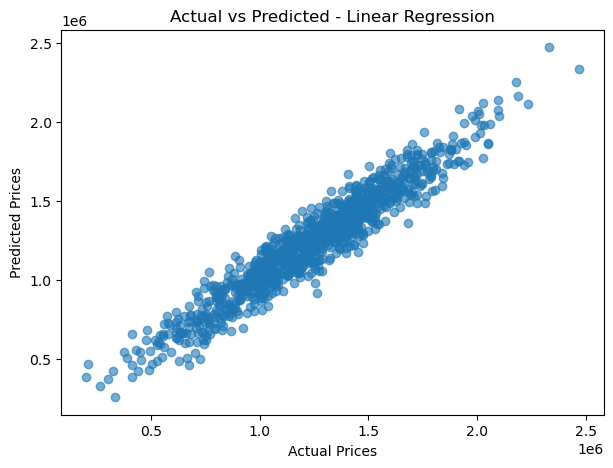

In [16]:
best_model_name = results_df.sort_values(by="R2 Score", ascending=False).iloc[0]["Model"]
best_model = models[best_model_name]

best_pipe = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", best_model)
])

best_pipe.fit(X_train, y_train)
best_pred = best_pipe.predict(X_test)

plt.figure(figsize=(7,5))
plt.scatter(y_test, best_pred, alpha=0.6)
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title(f"Actual vs Predicted - {best_model_name}")
plt.show()